1. Reads the rectangular extracted temperature and wind fields
2. Compute the mean temperature difference between offshore and onshore data.
3. Define an upwelling index from temperature contrast
4. Flatten the wind and temperature Xarray Dataset to Pandas Dataframe
5. Employ several machine learning algorithms for predicting the upwelling event using wind field.

## Import modules

In [1]:
from pathlib import Path
import xarray as xr
from dask.diagnostics import ProgressBar
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# reading data

In [2]:
# Locatio of the saved rectangles
data_path = "/home/jovyan/shared_materials/challenge_2_data/upwelling_rectangles_001/"

In [3]:
# Name of temperature and wind data
temp_data = sorted(Path(data_path).glob("temp*.nc"))
wind_data = sorted(Path(data_path).glob("wind*.nc"))

### temp

In [4]:
## Read and Extrapolate the temperature field to the location where the dataset is missing.
temp_ds = xr.open_mfdataset(temp_data, concat_dim="rectangle", combine="nested")

# compute the mean of temperature field for each pixel until the "max_depth" meter
max_depth = 20
temp_ds = temp_ds.sel(depth=slice(None, max_depth)).mean('depth')

# Extrapolate
temp_ds = temp_ds.interpolate_na(
    dim='AD',
    method='nearest',
    fill_value='extrapolate')

### wind

In [5]:
## Read and Extrapolate the wind field to the location where the dataset is missing.
wind_ds = xr.open_mfdataset(wind_data, concat_dim="rectangle", combine="nested")

# Extrapolate
wind_ds = wind_ds.interpolate_na(
    dim='AD',
    method='nearest',
    fill_value='extrapolate')

## Temperature contrast

In [6]:
def temperature_contrast(temp_ds, split=0.5):
    '''
    Compute the mean for the offshore and onshore and returns the contrast between the two region.

    Input:
        temp_ds: Dataset containing all temperature rectangle fields
        split: ratio between onshore and offshore to divide the regions.

    Output: 
        Difference between offshore and onshore mean temperature
    '''
    split_index = int(temp_ds.dims["AD"] * split)
    on_shore_temp = (
        temp_ds.thetao
        .isel(AD=slice(None, split_index))
        .mean(["AD", "AB"])
    )
    off_shore_temp = (
        temp_ds.thetao
        .isel(AD=slice(split_index, None))
        .mean(["AD", "AB"])
    )
    return off_shore_temp - on_shore_temp

In [7]:
labels = temperature_contrast(temp_ds).stack(sample=["rectangle", "time"])

In [10]:
with ProgressBar():
    labels = labels.compute()

[########################################] | 100% Completed | 10.92 ss


In [ ]:
labels.to_pandas().to_csv("labels.csv")
labels.to_pandas().plot.hist()
labels.to_pandas().describe()

## Upwelling index from temperature contrast

In [11]:
def get_temp_contrast_threshold(labels, quant=0.8):
    '''
    The function considers the quant ratio (e.g. 80%) of the
    temperature contrast between offshore and onshore mean temperature
    as the ratio to define the upwelling index.
    Input:
        Labels: temperature contrast between offshore and onshore mean temperature
        quant: the quantile to define the upwelling index higher that this ratio.
    Output:
        Boolean index True: upwelling, False: Not Upwelling
    '''
    labels = labels.to_pandas()
    return labels.where(labels > 0).dropna().quantile(quant)

In [15]:
binary_labels = (labels > get_temp_contrast_threshold(labels))
binary_labels.mean().compute()

<xarray.DataArray 'thetao' ()>
array(0.11944392)

## Plots

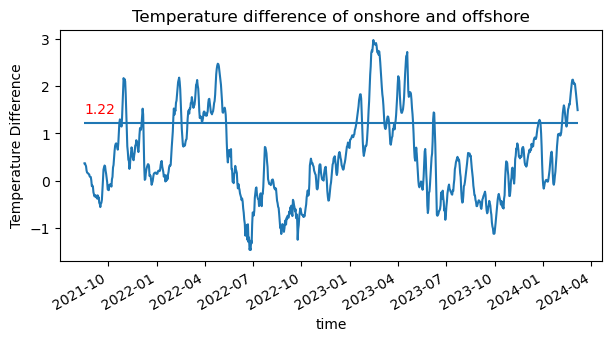

In [13]:
# Temperature contrast plot
rec = 20
rec_plot = labels.where(labels.rectangle==rec,drop=True)

fig, ax = plt.subplots(1,1, figsize=(7,3))
rec_plot.plot(x='time',ax=ax)
ax.set_title('Temperature difference of onshore and offshore')
ax.set_ylabel('Temperature Difference')
hvalue = get_temp_contrast_threshold(labels, quant=0.8)
ax.hlines(hvalue,xmin=np.min(labels.time),xmax=np.max(labels.time))
ax.text(x=np.min(labels.time),y=hvalue+0.2, s = f'{hvalue:.2f}', c='r');

plt.savefig('figure/temp_diff_threshold.jpg', dpi=600)

## Create temperature dataframe

Preparing the input to the machine learning algorithm

In [16]:
def get_temp_features(temp_ds):
    '''
    Flatten the temperature dataset features to Dataframe
    '''
    temp_features = (
        temp_ds
        .stack(sample=["rectangle", "time"])
        .stack(feature=["AD", "AB"])
        .drop(['latitude', 'longitude', 'target_lon', 'target_lat', 'rectangle', 'time', 'AD', 'AB'])
    )
    return temp_features

In [17]:
temp_features = get_temp_features(temp_ds)
temp_features_df = temp_features.thetao.to_dataframe().unstack(-1)
# temp_features_df.to_csv("temp_features.csv")

In [20]:
temp_features_df

thetao                                                         \
feature        0          1          2          3          4          5     
sample                                                                      
0        26.640221  26.759630  26.729416  26.720850  26.513824  26.414780   
1        26.823502  26.975615  26.978601  26.913620  26.785751  26.632782   
2        26.922661  26.948082  26.956329  26.856401  26.744024  26.556376   
3        27.049997  27.014158  26.942492  26.762293  26.714300  26.750914   
4        27.035416  26.914530  26.799337  26.581049  26.543325  26.618757   
...            ...        ...        ...        ...        ...        ...   
31717    24.009773  23.943110  23.871416  23.869528  23.946260  24.009649   
31718    23.965143  23.905676  23.841209  23.771551  23.838636  23.923426   
31719    23.983835  23.940260  23.893496  23.793655  23.801176  23.863352   
31720    24.053480  23.981565  23.970520  23.865763  23.764315  23.841982   
31721    24.221809  24.077286  24.010429  24.001436  23.843664  23.793467   

                                                     ...             \
feature        6          7          8          9    ...        290   
sample                                               ...              
0        26.511703  26.501244  26.501244  26.435440  ...  27.434675   
1        26.648249  26.603445  26.603445  26.549448  ...  27.554922   
2        26.598089  26.542747  26.542747  26.557856  ...  27.360216   
3        26.541742  26.578255  26.578255  26.591555  ...  27.168457   
4        26.447348  26.468521  26.468521  26.657806  ...  27.107214   
...            ...        ...        ...        ...  ...        ...   
31717    24.038582  24.092295  24.182823  24.162224  ...  24.037895   
31718    23.982048  24.037514  24.021769  23.935415  ...  23.943602   
31719    23.917292  23.950140  23.916727  23.845987  ...  23.827818   
31720    23.897049  23.919886  23.894045  23.838385  ...  23.737436   
31721    23.868193  23.901855  23.901854  23.879744  ...  23.641115   

                                                                           \
feature        291        292        293        294        295        296   
sample                                                                      
0        27.060575  27.406309  27.700876  27.284224  27.284224  27.034998   
1        27.462133  27.564585  27.775843  27.603104  27.603104  27.467102   
2        27.443933  27.450247  27.578150  27.448465  27.448465  27.675720   
3        27.376032  27.349335  27.346369  27.215250  27.215250  27.765387   
4        27.317774  27.328743  27.370010  27.317347  27.317347  27.857574   
...            ...        ...        ...        ...        ...        ...   
31717    24.015203  23.780306  23.397697  23.096479  22.972771  22.983358   
31718    23.742485  23.334616  22.951635  22.847551  22.938410  23.037882   
31719    23.568117  23.093473  22.789743  22.850401  22.989532  23.051023   
31720    23.383474  22.897345  22.801817  22.970528  23.081833  23.121161   
31721    23.232162  22.864061  22.912376  23.093002  23.174355  23.218681   

                                          
feature        297        298        299  
sample                                    
0        26.194551  25.886164  25.897247  
1        27.244967  26.815422  26.145136  
2        27.153488  27.059341  26.477438  
3        26.976309  26.958815  26.632492  
4        27.014528  27.117952  26.776350  
...            ...        ...        ...  
31717    23.067057  23.167383  23.203756  
31718    23.099001  23.120424  23.135241  
31719    23.089003  23.100708  23.111437  
31720    23.139830  23.149063  23.144182  
31721    23.238470  23.211920  23.151358  

[31722 rows x 300 columns]

## Create wind dataframe
Preparing the input to the machine learning algorithm

In [18]:
def get_wind_east_north_features(wind_ds):
    '''
    Flatten the wind dataset features to Dataframe
    '''
    wind_features = (
        wind_ds
        .to_array("varname")
        .stack(sample=["rectangle", "time"])
        .stack(feature=["AD", "AB", "varname"])
        .drop(['latitude', 'longitude', 'target_lon', 'target_lat', 'rectangle', 'time', 'AD', 'AB'])
        .rename("wind")
    )
    return wind_features

In [19]:
wind_features = get_wind_east_north_features(wind_ds)
wind_features_df = wind_features.to_dataframe().unstack(-1)
# wind_features_df.to_csv("wind_features.csv")

In [21]:
wind_features_df

wind                                                            \
feature       0         1             2         3         4             5     
sample                                                                        
0       -0.020556  0.000317  2.168313e-07 -0.020556  0.000317  2.168313e-07   
1       -0.018535  0.001565  3.297083e-07 -0.018535  0.001565  3.297083e-07   
2       -0.012587  0.002018 -2.191167e-07 -0.012587  0.002018 -2.191167e-07   
3       -0.012279 -0.004321  2.578333e-08 -0.012279 -0.004321  2.578333e-08   
4       -0.016625  0.018638 -3.040958e-07 -0.016625  0.018638 -3.040958e-07   
...           ...       ...           ...       ...       ...           ...   
31717   -0.140297 -0.149612 -5.380750e-07 -0.140297 -0.149612 -5.380750e-07   
31718   -0.206432 -0.145559 -1.002146e-06 -0.206432 -0.145559 -1.002146e-06   
31719   -0.132328 -0.094537 -8.787042e-07 -0.132328 -0.094537 -8.787042e-07   
31720   -0.085847 -0.065822 -2.984250e-07 -0.085847 -0.065822 -2.984250e-07   
31721   -0.064523 -0.082648  4.182917e-08 -0.064523 -0.082648  4.182917e-08   

                                                     ...                \
feature       6         7             8         9    ...           890   
sample                                               ...                 
0       -0.036918 -0.009597  2.307063e-07 -0.031809  ... -1.235063e-07   
1       -0.032667 -0.002955  3.854208e-07 -0.029016  ...  2.004333e-07   
2       -0.031840 -0.001929 -4.754583e-08 -0.024185  ... -5.038333e-08   
3       -0.024704 -0.009032  5.430417e-08 -0.021061  ...  1.552792e-07   
4       -0.028061  0.008224 -1.008813e-06 -0.023312  ...  1.950583e-07   
...           ...       ...           ...       ...  ...           ...   
31717   -0.124352 -0.143354  5.579500e-07 -0.112680  ... -2.940458e-07   
31718   -0.181026 -0.136721  6.909625e-07 -0.164950  ... -3.078958e-07   
31719   -0.119538 -0.091783  1.810042e-07 -0.104645  ... -6.530375e-07   
31720   -0.077240 -0.062868  3.743625e-07 -0.065390  ... -1.894833e-07   
31721   -0.055062 -0.080067  3.708417e-07 -0.042883  ... -2.203292e-07   

                                                                             \
feature       891       892           893       894       895           896   
sample                                                                        
0       -0.022929 -0.016806 -1.263313e-07 -0.021745 -0.022582 -3.800375e-07   
1       -0.024932 -0.015616  1.977125e-07 -0.022572 -0.023608  1.572458e-07   
2       -0.035013 -0.021199  2.181250e-08 -0.029920 -0.030209  1.214083e-07   
3       -0.018393 -0.017161 -2.761750e-07 -0.017687 -0.027205 -5.096417e-07   
4       -0.031313  0.001876 -4.653833e-07 -0.030960 -0.003146 -1.110808e-06   
...           ...       ...           ...       ...       ...           ...   
31717   -0.172805 -0.174259 -2.940458e-07 -0.175084 -0.178551 -3.650750e-07   
31718   -0.237884 -0.158469 -3.078958e-07 -0.242464 -0.166636 -6.556375e-07   
31719   -0.165159 -0.105016 -6.530375e-07 -0.170395 -0.108627 -7.374500e-07   
31720   -0.094017 -0.069169 -1.894833e-07 -0.098485 -0.071489 -3.599000e-07   
31721   -0.063362 -0.080918 -2.203292e-07 -0.066538 -0.084005 -3.759375e-07   

                                           
feature       897       898           899  
sample                                     
0       -0.017179 -0.004942 -8.153750e-08  
1       -0.022340  0.002093  1.530167e-07  
2       -0.021742 -0.003465  1.361875e-07  
3       -0.012744 -0.013929 -1.636792e-07  
4       -0.029440  0.014073  4.668083e-07  
...           ...       ...           ...  
31717   -0.175084 -0.178551 -3.650750e-07  
31718   -0.242464 -0.166636 -6.556375e-07  
31719   -0.170395 -0.108627 -7.374500e-07  
31720   -0.098485 -0.071489 -3.599000e-07  
31721   -0.066538 -0.084005 -3.759375e-07  

[31722 rows x 900 columns]

# Machine Learning Algorithm

## Import ML modules 

In [24]:
# Import necessary libraries
import numpy as np
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix

# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

## TSNE

In [ ]:
tsne = TSNE(n_components=2)
tsne

In [ ]:
plt.plot(
    tsne.fit_transform(
        wind_features.isel(sample=slice(None, None, 100), 
                           feature=slice(600, None)).data)
    , '.')

In [ ]:
lr = LinearRegression()
lr

In [ ]:
lr.fit(
    wind_features.isel(sample=slice(None, None, 10)), 
    labels.isel(sample=slice(None, None, 10)),
)

In [ ]:
plt.plot(
    lr.predict(wind_features.isel(sample=slice(None, None, 10))),
    labels.isel(sample=slice(None, None, 10)),
    'b.'
)

plt.plot(
    lr.predict(wind_features.isel(sample=slice(1, None, 10))),
    labels.isel(sample=slice(1, None, 10)),
    'r.'
)

## Split dataset

In [25]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(wind_features_df, binary_labels, test_size=0.2, random_state=42)

### Random Forest

In [26]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [27]:
# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.903230890464933


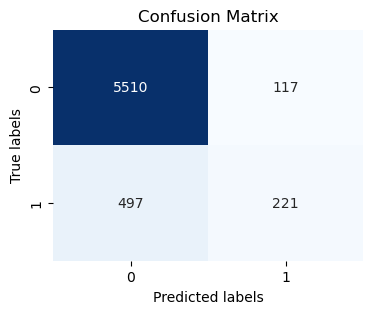

In [28]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

## Split dataset with lagged wind field

In [30]:
# Sliding window size
window_size = 3

# Initialize lists to store input features and target labels
X_lagged = []
y_lagged = []

# Iterate over the dataset to create sliding windows
for i in range(len(wind_features_df) - window_size):
    # Extract the window of data for the current day and previous two days
    window_data = wind_features_df.iloc[i:i+window_size]
    
    # Concatenate the data from the window to create input feature vector
    input_feature = window_data.values.flatten()
    
    # Append the input feature vector to the list of input features
    X_lagged.append(input_feature)
    
    # Assume the target label is the value for the day after the window
    target_label = binary_labels.isel(sample=i+window_size).values
    
    # Append the target label to the list of target labels
    y_lagged.append(target_label)

# Convert lists to numpy arrays
X_lagged = np.array(X_lagged)
y_lagged = np.array(y_lagged)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_lagged, y_lagged, test_size=0.2, random_state=42)

### Random Forest

In [31]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [43]:
# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# F1-score
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

# Area under the ROC curve (AUC-ROC)
auc_roc = roc_auc_score(y_test, y_pred)
print("AUC-ROC:", auc_roc)


Accuracy: 0.9043190416141236
Precision: 0.7068493150684931
Recall: 0.3403693931398417
F1-score: 0.4594835262689225
AUC-ROC: 0.6606071813533079


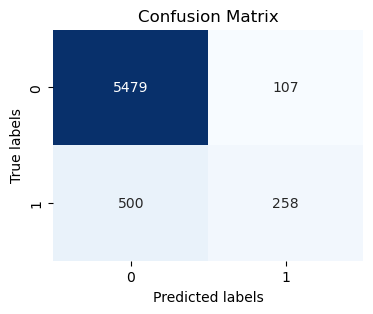

In [33]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
# plt.show()
plt.savefig()

## Other models

In [ ]:
# Initialize the classifier
# Example: Support Vector Machine (SVM)
classifier = KNeighborsClassifier()  # You can replace this with any classifier from the list above

# Train the classifier on the training data
classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = classifier.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)

# Print or use the evaluation metrics as needed

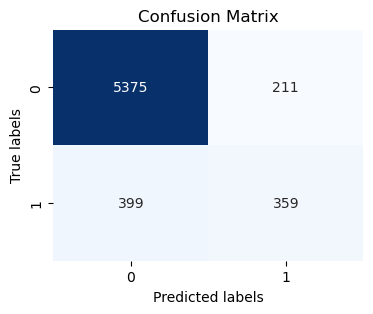

In [42]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
# plt.show()
plt.savefig('figure/confusion_matrix_lagged_data.jpg', bbox_inches='tight')

## Regression

Split data temperature contrast to train, test batch

In [44]:
# Sliding window size
window_size = 3

# Initialize lists to store input features and target labels
X_lagged = []
y_lagged = []

# Iterate over the dataset to create sliding windows
for i in range(len(wind_features_df) - window_size):
    # Extract the window of data for the current day and previous two days
    window_data = wind_features_df.iloc[i:i+window_size]
    
    # Concatenate the data from the window to create input feature vector
    input_feature = window_data.values.flatten()
    
    # Append the input feature vector to the list of input features
    X_lagged.append(input_feature)
    
    # Assume the target label is the value for the day after the window
    target_label = labels.isel(sample=i+window_size).values
    
    # Append the target label to the list of target labels
    y_lagged.append(target_label)

# Convert lists to numpy arrays
X_lagged = np.array(X_lagged)
y_lagged = np.array(y_lagged)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_lagged, y_lagged, test_size=0.2, random_state=42)

In [78]:
# Initialize the classifier
# Example: Support Vector Machine (SVM)
classifier = KNeighborsRegressor()  # You can replace this with any classifier from the list above

# Train the classifier on the training data
classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = classifier.predict(X_test)

# # Calculate evaluation metrics
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# auc_roc = roc_auc_score(y_test, y_pred)


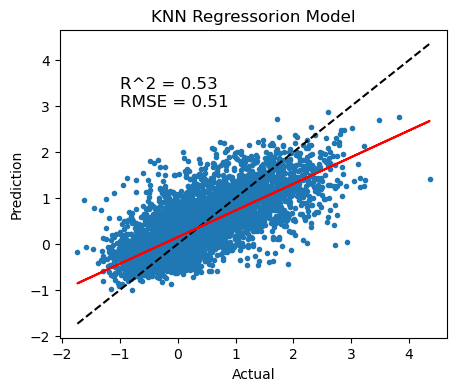

In [80]:


fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.plot(y_test , y_pred, '.')
ax.set_title('KNN Regressorion Model')
ax.set_xlabel('Actual')
ax.set_ylabel('Prediction')


# Calculate R^2 score
r2 = r2_score(y_test, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
ax.text(-1, 3, f'R^2 = {r2:.2f}\nRMSE = {rmse:.2f}', fontsize=12)

# Plot one-to-one line
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--', label='One-to-One Line')
# Fit linear regression to the data
regression_model = LinearRegression()
regression_model.fit(y_test.reshape(-1, 1), y_pred)

# Predict y_pred using the regression model
y_pred_regression = regression_model.predict(y_test.reshape(-1, 1))

# Plot regression line
plt.plot(y_test, y_pred_regression, color='red', label='Regression Line')

# Annotate the plot with regression line equation
# coefficients = regression_model.coef_[0]
# intercept = regression_model.intercept_
# equation = f'y_pred = {coefficients:.2f} * y_test + {intercept:.2f}'
# plt.text(0.05, 0.9, equation, ha='left', va='top', transform=plt.gca().transAxes, fontsize=12, color='black')


# plt.savefig('figure/regression_results.jpg', dpi=600)